In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from typing import Callable, Dict, List, Optional, Tuple, Union

import mne
from mne.io.edf.edf import RawEDF

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
from utils.read_data import read_data

from utils.re_referencing import rref_REST, rref_remove, rref_CSD, rref_average

from utils.data_filtering import filter_band_raw_to_raw, filter_band_array_to_array
from utils.data_filtering import eliminate_blink_corr_electrodes
from utils.data_filtering import clean_windows_artifacts, reconstruct_signal

from metrics import analyse_network_by_metric

DEBUG:root:test


In [3]:
# Load data, filter on 0.1-100 [Hz] and rref REST
raw = read_data("../data/h01.edf")
raw_filtered = filter_band_raw_to_raw(raw, [0.1, 100])
raw_rref = rref_REST(raw_filtered)

Extracting EDF parameters from /home/jarajaras/dynamicinfo-eeg/data/h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 231249  =      0.000 ...   924.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 8251 samples (33.004 sec)



In [4]:
from utils import create_virtual_channel

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/jarajaras/anaconda3/envs/eeg-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


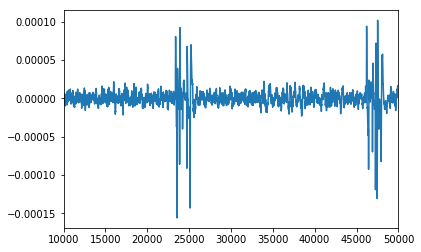

In [5]:
virtual_channel = create_virtual_channel(raw_filtered, ["Fp1", "Fp2"])
plt.plot(virtual_channel)
plt.xlim(10000, 50000)
plt.show()

In [6]:
#raw.plot(title = "Raw")
#raw_filtered.plot(title = "Raw Filtered")
#raw_rref.plot(title = "Raw Filtered and re-ref")
#plt.show()

In [7]:
# Plot the power spectral density across channels.
#raw.plot_psd() 
#raw_filtered.plot_psd() 
#raw_rref.plot_psd()
#plt.show()

In [8]:
# Params
reconst_threshold = 0.2

## with raw_filteres (not re-ref)
reconst_raw, ica, eliminated_comps = reconstruct_signal(raw_filtered, reconst_threshold, ch_names=["Fp1", "Fp2"]) #[ 0  1  5  6 13 16]
#reconst_raw, ica, eliminated_comps = reconstruct_signal(raw_filtered, reconst_threshold, ch_names=["Fp1", "Fp2", "O1", "O2"]) #[ 0  1  5  6 16]

## with Re-ref. Not working
#reconst_raw, ica, eliminated_comps = reconstruct_signal(raw_rref, reconst_threshold, ch_names=["Fp1", "Fp2"]) #[ 0  1  5  6 13 16]

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
    Rejecting  epoch based on EEG : ['O1']
Artifact detected in [11000, 11500]
    Rejecting  epoch based on EEG : ['O2']
Artifact detected in [21000, 21500]
    Rejecting  epoch based on EEG : ['Fp2', 'Fp1']
Artifact detected in [23500, 24000]
    Rejecting  epoch based on EEG : ['Fp2', 'Fp1']
Artifact detected in [24500, 25000]
    Rejecting  epoch based on EEG : ['Fp2', 'Fp1']
Artifact detected in [25000, 25500]
    Rejecting  epoch based on EEG : ['O2']
Artifact detected in [28500, 29000]
    Rejecting  epoch based on EEG : ['Fp2', 'Fp1']
Artifact detected in [46000, 46500]
    Rejecting  epoch based on EEG : ['Fp2', 'Fp1']
Artifact detected in [47000, 47500]
    Rejecting  epoch based on EEG : ['Fp2', 'Fp1']
Artifact detected in [47500, 48000]
    Rejecting  epoch based on EEG : ['O1']
Artifact detected in [52000, 52500]
    Rejecting  epoch based on EEG : ['O2'

DEBUG:matplotlib.backends:backend nbAgg version unknown


<IPython.core.display.Javascript object>


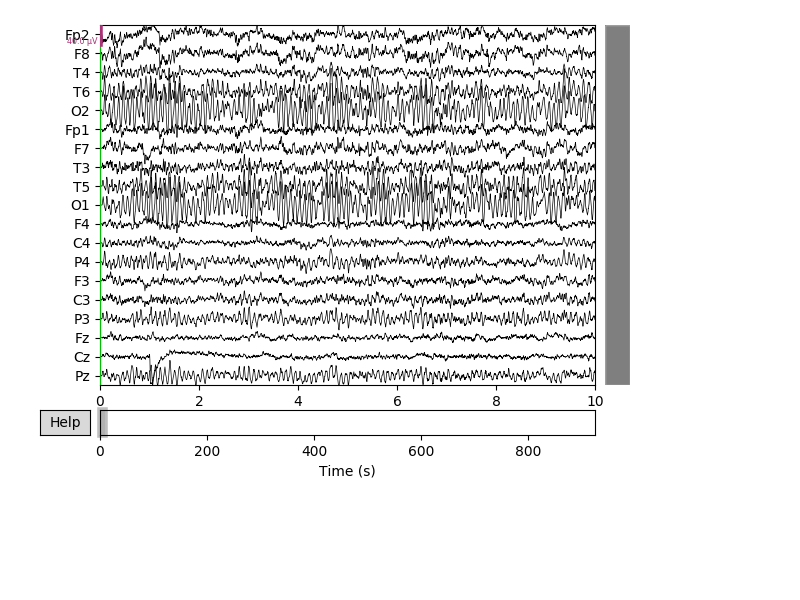

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=5.789999999999999 to DejaVu Sans ('/home/jarajaras/anaconda3/envs/eeg-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


<IPython.core.display.Javascript object>


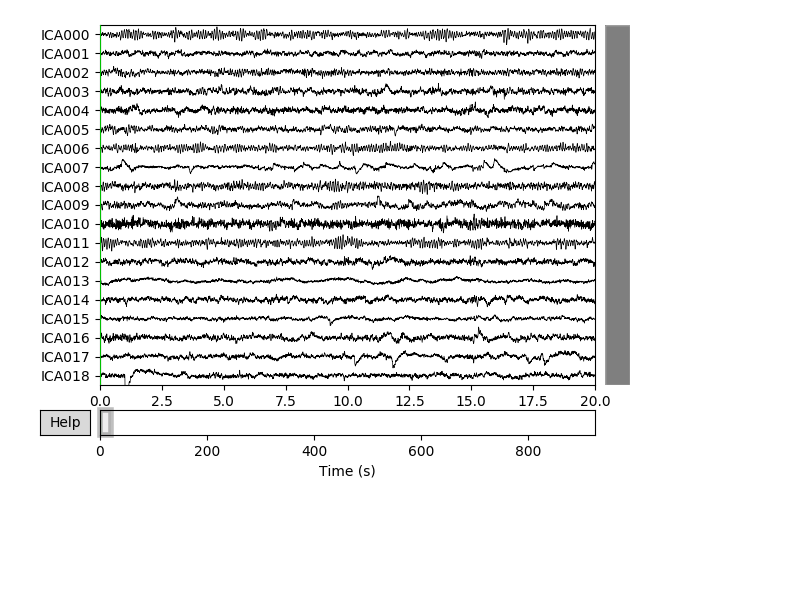

In [9]:
# Comparison between raw_REST and raw_ica
%matplotlib notebook
raw_filtered.plot()
ica.plot_sources(raw_filtered)
plt.show()

In [12]:
# [ ] Verificar para todos los sujetos
# Params
window_time = 10
clean_threshold = 0.6

# Cleaning
data_windows, rejected = clean_windows_artifacts(reconst_raw, 
                                                 window_time=window_time, 
                                                 std_threshold=clean_threshold, 
                                                 rref_fn=rref_REST
                                                )

INFO:root:window number 9 rejected
INFO:root:window number 28 rejected
INFO:root:window number 32 rejected
INFO:root:window number 33 rejected
INFO:root:window number 36 rejected
INFO:root:window number 58 rejected
INFO:root:window number 61 rejected
INFO:root:window number 64 rejected
INFO:root:window number 67 rejected
INFO:root:window number 70 rejected
INFO:root:window number 73 rejected
INFO:root:window number 81 rejected
INFO:root:window number 82 rejected
INFO:root:window number 83 rejected
INFO:root:window number 84 rejected


In [10]:
# Project mixing matrix on interpolated sensor topography.
#ica.plot_components(inst=raw_REST) 

In [11]:
#ica.plot_overlay(raw_filtered, exclude=eliminated_comps)
#plt.show()

DEBUG:matplotlib.backends:backend nbAgg version unknown


<IPython.core.display.Javascript object>


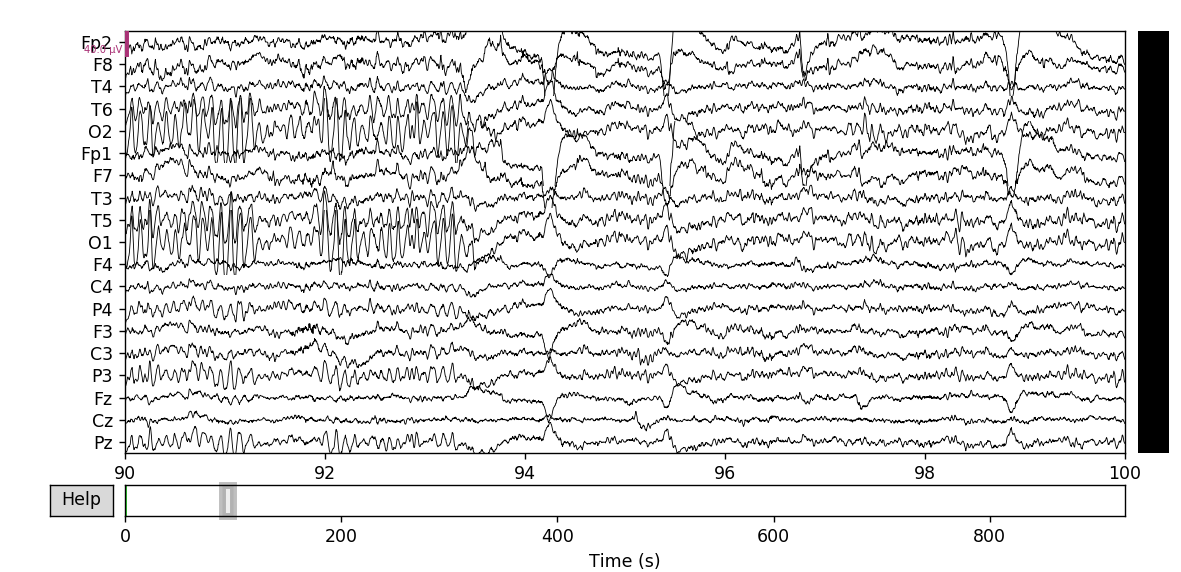

<IPython.core.display.Javascript object>


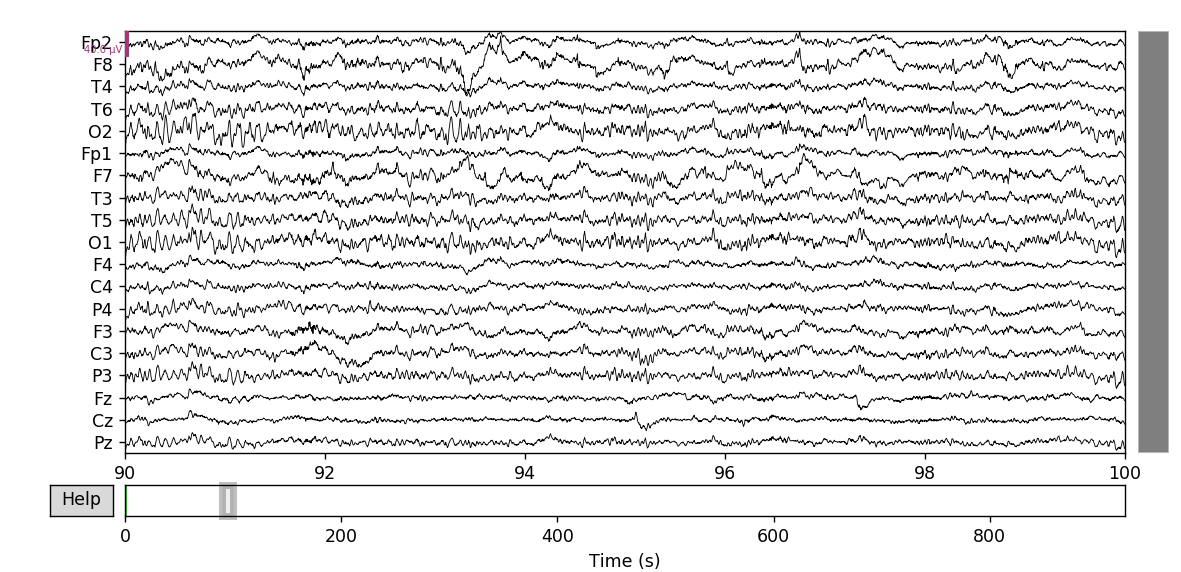

In [26]:
# [ ] Ventana que comience con % de la anterior.
%matplotlib notebook
start = window_time*rejected[0] # 92, 185, 276 (h01)

raw_filtered.plot(start=start)
#ica.plot_sources(raw_filtered, start=start)
reconst_raw.plot(start=start) # not re-ref
#rref_REST(reconst_raw).plot(start=start)
#rref_REST(filter_band_raw_to_raw(reconst_raw, band="alpha")).plot(start=start)
plt.show()

In [14]:
data_windows.shape

(77, 19, 2500)

In [15]:
all_data = np.concatenate(data_windows, axis=1)
all_data.shape

(19, 192500)

In [16]:
def create_tt(window_time: int, n_samples: int, i_window: int):
    return np.linspace(0, window_time, n_samples)+(i_window*window_time)

In [17]:
i_window = 0
i_channel = 16
max_lag = 20

settings = {
     'cmi_estimator':  'OpenCLKraskovCMI',
     'max_lag': max_lag,
     'local_values': True,
     'n_perm_max_stat': 11,
     'n_perm_min_stat': 11,
     'alpha_max_stat': 0.1,
     'n_perm_omnibus': 11,
     'alpha_omnibus': 0.1,
     'n_perm_max_seq': 11,
     'alpha_max_seq': 0.1, 
     'alpha_min_stat': 0.1,
     'verbose': False
}

# Calculating AIS
n_samples = data_windows.shape[-1]
tt = create_tt(window_time, n_samples, i_window)
net_analysis = analyse_network_by_metric(data_windows[i_window], channels=i_channel, metric="AIS", **settings)
ais = net_analysis.get_single_process(0)['ais'][0]

DEBUG:pyopencl.cache:build program: binary cache hit (key: 4c19e71bfee36c280304a8a17e37db26)
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: disk cache hit [key=9830e4e464ac850c53a15d29fb1ea0822392841646effb7ab7351bc85139fdf0]
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: disk cache hit [key=b0be9d43833a6a67bdabcaf743eafe38855ffce6660ec5502b12c36615acb806]
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: disk cache hit [key=b4efd189bde0f677b380b90ad80abcdf9858b798940c0e9f9b0bfc8b6beb4077]
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: disk cache hit [key=fb92d9fdefe95aeac01927058216ade6f72b3d21cc609bafdbf44c1b956191a5]


Adding data with properties: 1 processes, 2500 samples, 1 replications
overwriting existing data


DEBUG:pyopencl.cache:build program: binary cache hit (key: 4c19e71bfee36c280304a8a17e37db26)
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=9830e4e464ac850c53a15d29fb1ea0822392841646effb7ab7351bc85139fdf0]
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=b0be9d43833a6a67bdabcaf743eafe38855ffce6660ec5502b12c36615acb806]
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=b4efd189bde0f677b380b90ad80abcdf9858b798940c0e9f9b0bfc8b6beb4077]
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=fb92d9fdefe95aeac01927058216ade6f72b3d21cc609bafdbf44c1b956191a5]
DEBUG:pyopencl.cache:build program: binary cache hit (key: 4c19e71bfee36c280304a8a17e37db26)
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=9830e4e464ac850c53a15d29fb1ea0822392841646effb7ab7351bc85139fdf0]
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=b0be9d4383


---------------------------- (1) include candidates



DEBUG:pyopencl.cache:build program: binary cache hit (key: 4c19e71bfee36c280304a8a17e37db26)
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=9830e4e464ac850c53a15d29fb1ea0822392841646effb7ab7351bc85139fdf0]
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=b0be9d43833a6a67bdabcaf743eafe38855ffce6660ec5502b12c36615acb806]
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=b4efd189bde0f677b380b90ad80abcdf9858b798940c0e9f9b0bfc8b6beb4077]
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=fb92d9fdefe95aeac01927058216ade6f72b3d21cc609bafdbf44c1b956191a5]
DEBUG:pyopencl.cache:build program: binary cache hit (key: 4c19e71bfee36c280304a8a17e37db26)
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=9830e4e464ac850c53a15d29fb1ea0822392841646effb7ab7351bc85139fdf0]
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=b0be9d4383

DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=b0be9d43833a6a67bdabcaf743eafe38855ffce6660ec5502b12c36615acb806]
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=b4efd189bde0f677b380b90ad80abcdf9858b798940c0e9f9b0bfc8b6beb4077]
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=fb92d9fdefe95aeac01927058216ade6f72b3d21cc609bafdbf44c1b956191a5]
DEBUG:pyopencl.cache:build program: binary cache hit (key: 4c19e71bfee36c280304a8a17e37db26)
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=9830e4e464ac850c53a15d29fb1ea0822392841646effb7ab7351bc85139fdf0]
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=b0be9d43833a6a67bdabcaf743eafe38855ffce6660ec5502b12c36615acb806]
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=b4efd189bde0f677b380b90ad80abcdf9858b798940c0e9f9b0bfc8b6beb4077]
DEBUG:pytools.persistent_dict:pyopenc


---------------------------- (2) prune source candidates

---------------------------- (3) final statistics


DEBUG:pyopencl.cache:build program: binary cache hit (key: 4c19e71bfee36c280304a8a17e37db26)
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=9830e4e464ac850c53a15d29fb1ea0822392841646effb7ab7351bc85139fdf0]
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=b0be9d43833a6a67bdabcaf743eafe38855ffce6660ec5502b12c36615acb806]
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=b4efd189bde0f677b380b90ad80abcdf9858b798940c0e9f9b0bfc8b6beb4077]
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=fb92d9fdefe95aeac01927058216ade6f72b3d21cc609bafdbf44c1b956191a5]
DEBUG:pyopencl.cache:build program: binary cache hit (key: 4c19e71bfee36c280304a8a17e37db26)
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=9830e4e464ac850c53a15d29fb1ea0822392841646effb7ab7351bc85139fdf0]
DEBUG:pytools.persistent_dict:pyopencl-invoker-cache-v7: in mem cache hit [key=b0be9d4383

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.0 to DejaVu Sans ('/home/jarajaras/anaconda3/envs/eeg-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0 to DejaVu Sans ('/home/jarajaras/anaconda3/envs/eeg-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


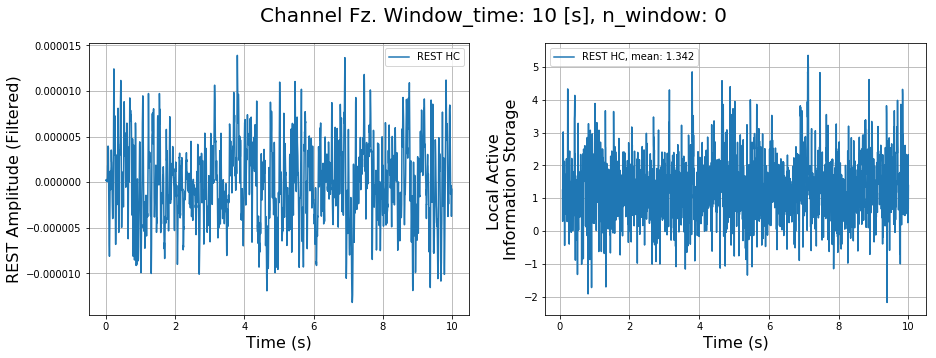

In [18]:
%matplotlib inline

title = f"Window_time: {window_time} [s], n_window: {i_window}"
# Plotting
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(tt, data_windows[i_window, i_channel], label='REST HC')       
ax[0].set_xlabel('Time (s)', fontsize=16)
ax[0].set_ylabel('REST Amplitude (Filtered)', fontsize=16)
ax[0].grid()
ax[0].legend()

ax[1].plot(tt[max_lag:], ais,
          label=f"REST HC, mean: {ais.mean():.3f}"
          )
ax[1].set_ylabel('Local Active \nInformation Storage', fontsize=16)
ax[1].set_xlabel('Time (s)', fontsize=16)
ax[1].grid()
ax[1].legend()
plt.suptitle(f'Channel {raw.info["ch_names"][i_channel]}. ' + title, fontsize=20)
plt.show()